In [2]:
pip install numpy torch botorch gpytorch scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
file_path = 'Combined_set_prescreened.csv'
total_info = pd.read_csv(file_path)
total_info

MOF  uptake_ads  uptake_des  \
0                                   XUKYEI_neutral    0.920997    0.668303   
1                           ja300034j_si_002_clean    0.433112    0.187346   
2                                   QIYDAF01_clean    0.827077    0.660425   
3                                     XAHPIH_clean    0.818678    0.634451   
4                                     VETMIS_clean    0.932519    0.746597   
...                                            ...         ...         ...   
7180                                  AQOTIK_clean    0.026746    0.110716   
7181  acs.inorgchem.6b00276_ic6b00276_si_006_clean    0.421515    0.395023   
7182  acs.inorgchem.6b01762_ic6b01762_si_002_clean    0.087637    0.074696   
7183  acs.inorgchem.6b02696_ic6b02696_si_002_clean    0.294982    0.280449   
7184              acscombsci.5b00188_5036495_clean    0.549701    0.613880   

      heat_ads  heat_des      LISD      LFSD     LISFS  Unit_cell_volume  \
0    -21.55231 -18.39099  13.18217  10.20370  13.18217          6140.000   
1    -25.96441 -17.79542  17.49700  17.44104  17.49700          2800.680   
2    -19.37443 -18.95302  22.00141  13.48659  22.00141         52812.600   
3    -21.96228 -19.54395  14.37026  13.22660  14.37026         12821.800   
4    -22.10557 -19.92746  18.13430  11.96931  18.13430         33152.200   
...        ...       ...       ...       ...       ...               ...   
7180 -18.38246 -39.26981   6.80588   3.86300   6.80588           702.348   
7181 -39.33925       NaN  14.12459   8.71298  14.12459         54783.400   
7182 -30.35526       NaN  11.40609   8.52606  11.40609         23358.100   
7183 -34.78612       NaN  12.11622   5.03656  12.11622         70922.000   
7184 -18.93596       NaN  11.02841   8.71025  10.83963          3529.750   

       Density  ...    O  La  Cr  Ti  Ba  Rh  Ce  Cu  Al  Re  
0     0.287208  ...    0   0   0   0   0   0   0   2   0   0  
1     0.713223  ...   18   0   0   0   0   0   0   0   0   0  
2     0.303251  ...   96   0   0   0   0   0   0  24   0   0  
3     0.356183  ...   40   0   0   0   0   0   0   8   0   0  
4     0.311959  ...   48   0   0   0   0   0   0  12   0   0  
...        ...  ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
7180  1.473480  ...    0   0   0   0   0   0   0   0   0   0  
7181  0.761320  ...  240   0   0   0   0   0   0   0   0   0  
7182  2.311980  ...  548   0   0   0   0   0   0   0   0   0  
7183  0.908718  ...  384   0   0   0   0   0   0   0   0   0  
7184  0.338372  ...   10   0   0   0   0   0   0   0   0   0  

[7185 rows x 111 columns]

In [4]:
total_info=total_info.dropna()
total_info

MOF  uptake_ads  uptake_des  heat_ads  heat_des  \
0             XUKYEI_neutral    0.920997    0.668303 -21.55231 -18.39099   
1     ja300034j_si_002_clean    0.433112    0.187346 -25.96441 -17.79542   
2             QIYDAF01_clean    0.827077    0.660425 -19.37443 -18.95302   
3               XAHPIH_clean    0.818678    0.634451 -21.96228 -19.54395   
4               VETMIS_clean    0.932519    0.746597 -22.10557 -19.92746   
...                      ...         ...         ...       ...       ...   
7176            AQIXUU_clean    0.001177    0.062873 -25.56586 -49.26611   
7177            AFOVOH_clean    0.165457    0.232918 -28.96937 -40.77527   
7178           ATIJUJ_manual    0.038061    0.186922 -10.98116 -19.63789   
7179            AFOVEX_clean    0.172913    0.244083 -29.31178 -38.54721   
7180            AQOTIK_clean    0.026746    0.110716 -18.38246 -39.26981   

          LISD      LFSD     LISFS  Unit_cell_volume   Density  ...   O  La  \
0     13.18217  10.20370  13.18217          6140.000  0.287208  ...   0   0   
1     17.49700  17.44104  17.49700          2800.680  0.713223  ...  18   0   
2     22.00141  13.48659  22.00141         52812.600  0.303251  ...  96   0   
3     14.37026  13.22660  14.37026         12821.800  0.356183  ...  40   0   
4     18.13430  11.96931  18.13430         33152.200  0.311959  ...  48   0   
...        ...       ...       ...               ...       ...  ...  ..  ..   
7176   5.00071   3.78897   5.00071           787.077  2.316180  ...  18   0   
7177   8.74251   6.51591   8.19585          1598.690  1.048160  ...  12   0   
7178  17.44029  16.95446  17.44029          3081.950  0.753394  ...  18   0   
7179   8.76979   6.57643   8.76042          1626.110  1.022060  ...  12   0   
7180   6.80588   3.86300   6.80588           702.348  1.473480  ...   0   0   

      Cr  Ti  Ba  Rh  Ce  Cu  Al  Re  
0      0   0   0   0   0   2   0   0  
1      0   0   0   0   0   0   0   0  
2      0   0   0   0   0  24   0   0  
3      0   0   0   0   0   8   0   0  
4      0   0   0   0   0  12   0   0  
...   ..  ..  ..  ..  ..  ..  ..  ..  
7176   0   0   0   0   0   0   0   0  
7177   0   0   0   0   0   0   0   0  
7178   0   0   0   0   0   0   0   0  
7179   0   0   0   0   2   0   0   0  
7180   0   0   0   0   0   0   0   0  

[7181 rows x 111 columns]

In [5]:
# Data preprocessing
total_info_cleaned = total_info.dropna()
uptake_ads = total_info_cleaned['uptake_ads']
uptake_des = total_info_cleaned['uptake_des']
heat_ads = total_info_cleaned['heat_ads']
heat_des = total_info_cleaned['heat_des']

# Given constants
delta_H_vap_Tev = 16.25          # Example value in kJ/mol
M_w = 0.044097                   # Molar mass in kg/mol
C_sorbent_p = 1                  # Specific heat capacity in kJ/(kg*K)
T_des = 358.15                   # Desorption temperature in Kelvin
T1 = 313.13                      # Initial temperature in Kelvin

# Calculate Δq
delta_q = uptake_ads - uptake_des

# Drop rows with negative Δq
filtered_indices = delta_q >= 0
total_info_cleaned = total_info_cleaned[filtered_indices].copy()
delta_q = delta_q[filtered_indices]

# Calculate <ΔH_ads>
avg_delta_H_ads = (heat_ads + heat_des) / 2
avg_delta_H_ads = avg_delta_H_ads[filtered_indices]

# Calculate COP_R for each row
total_info_cleaned.loc[:, 'COP_R'] = (delta_H_vap_Tev * delta_q) / ((M_w * C_sorbent_p * (T_des - T1)) - (delta_q * avg_delta_H_ads))

# Select target and features
target = total_info_cleaned['COP_R']
features = total_info_cleaned.drop(columns=["MOF", "uptake_ads", "heat_ads", "uptake_des", "heat_des", "Pu", "COP_R"])

# Convert to numpy arrays
X = features.values
y = target.values
total_info_cleaned.values[6]

array(['CUSXIY_clean', 0.7002765320977, 0.5725215539988, -18.03611,
       -16.355, 15.36203, 13.23891, 14.90651, 67549.9, 0.291845, 10668.5,
       1579.35, 5411.61, 0.0, 0.0, 0.0, 1, 10668.5, 0, 42678.0, 0.6318,
       2.16485, 0.0, 0.0, 0.0, 42678.0, 0, 0, 0.0, 0.0, 1, 15.362,
       13.2389, 14.9065, 288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 576, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0.49640991873421036], dtype=object)

In [6]:
total_info_cleaned=total_info_cleaned.drop(columns=["Pu","uptake_ads","uptake_des","heat_ads","heat_des","MOF"])

In [7]:
total_info_cleaned

LISD      LFSD     LISFS  Unit_cell_volume   Density     ASA_A2  \
0     13.18217  10.20370  13.18217          6140.000  0.287208  1122.8100   
1     17.49700  17.44104  17.49700          2800.680  0.713223   390.5410   
2     22.00141  13.48659  22.00141         52812.600  0.303251  8995.1500   
3     14.37026  13.22660  14.37026         12821.800  0.356183  2130.4900   
4     18.13430  11.96931  18.13430         33152.200  0.311959  5856.6500   
...        ...       ...       ...               ...       ...        ...   
6912   6.56302   4.77517   6.56302          3664.890  1.599000   394.0410   
6913   5.67220   3.42753   4.50995          1630.010  2.827110    75.6807   
6914   4.90669   3.50214   4.90669           847.141  1.567280    37.4215   
6915   5.16636   4.13343   5.13222         17478.700  2.019600   806.0660   
6916   4.48832   3.71412   4.48832          1478.360  1.547160    47.6128   

      ASA_m2_per_cm3  ASA_m2_per_g  NASA_A2  NASA_m2_per_cm3  ...  La  Cr  Ti  \
0           1828.680      6367.080   0.0000            0.000  ...   0   0   0   
1           1394.450      1955.140   0.0000            0.000  ...   0   0   0   
2           1703.220      5616.540   0.0000            0.000  ...   0   0   0   
3           1661.620      4665.070   0.0000            0.000  ...   0   0   0   
4           1766.600      5662.900   0.0000            0.000  ...   0   0   0   
...              ...           ...      ...              ...  ...  ..  ..  ..   
6912        1075.180       672.406   0.0000            0.000  ...   0   0   0   
6913         464.295       164.230  67.0363          411.263  ...   0   0   0   
6914         441.738       281.850   0.0000            0.000  ...   0   0   0   
6915         461.169       228.346   0.0000            0.000  ...   0   0   0   
6916         322.064       208.165   0.0000            0.000  ...   0   0   0   

      Ba  Rh  Ce  Cu  Al  Re     COP_R  
0      0   0   0   2   0   0  0.583945  
1      0   0   0   0   0   0  0.542431  
2      0   0   0  24   0   0  0.522907  
3      0   0   0   8   0   0  0.515395  
4      0   0   0  12   0   0  0.512710  
...   ..  ..  ..  ..  ..  ..       ...  
6912   0   0   0   0   0   0  0.000327  
6913   2   0   0   0   0   0  0.000246  
6914   0   0   0   0   0   0  0.000137  
6915   0   0   0  64   0   0  0.000066  
6916   0   0   0   0   0   0  0.000000  

[6917 rows x 106 columns]

In [8]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scipy.stats import norm
import pandas as pd
import time
import pickle

In [9]:
X

array([[13.18217, 10.2037 , 13.18217, ...,  2.     ,  0.     ,  0.     ],
       [17.497  , 17.44104, 17.497  , ...,  0.     ,  0.     ,  0.     ],
       [22.00141, 13.48659, 22.00141, ..., 24.     ,  0.     ,  0.     ],
       ...,
       [ 4.90669,  3.50214,  4.90669, ...,  0.     ,  0.     ,  0.     ],
       [ 5.16636,  4.13343,  5.13222, ..., 64.     ,  0.     ,  0.     ],
       [ 4.48832,  3.71412,  4.48832, ...,  0.     ,  0.     ,  0.     ]])

In [10]:
# Define Bayesian optimization function
def bo_run(X, y, nb_iterations, nb_COFs_initialization, which_acquisition, verbose=False, store_explore_exploit_terms=False):
    assert nb_iterations > nb_COFs_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

    # Select initial COFs for training data randomly
    ids_acquired = np.random.choice(np.arange(X.shape[0]), size=nb_COFs_initialization, replace=False)

    # Keep track of exploration vs. exploitation terms ONLY for when using EI  
    if which_acquisition == "EI" and store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    else:
        explore_exploit_balance = []

    # Initialize acquired y
    y_acquired = y[ids_acquired]

    for i in range(nb_COFs_initialization, nb_iterations):
        print("iteration:", i, end="\r")
        
        # Construct and fit GP model
        model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        
        # Fit the GP model
        model.train()
        mll.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()
        
        # Set up acquisition function
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())
        elif which_acquisition == "max y_hat":
            acquisition_function = PosteriorMean(model)
        elif which_acquisition == "max sigma":
            acquisition_function = UpperConfidenceBound(model, beta=0.1)
        else:
            raise Exception("not a valid acquisition function")

        # Optimize the acquisition function
        new_x, _ = optimize_acqf(
            acquisition_function,
            bounds=torch.stack([torch.tensor(X.min(0)), torch.tensor(X.max(0))], 0).to(torch.float32),
            q=1,
            num_restarts=10,
            raw_samples=20,
        )

        # Convert new_x to numpy
        new_x_np = new_x.detach().numpy().reshape(-1)

        # Find the closest point in the dataset (to avoid duplicates)
        distances = np.sum((X - new_x_np)**2, axis=1)
        id_max_acquisition = np.argmin(distances)

        # Acquire this COF
        ids_acquired = np.concatenate((ids_acquired, [id_max_acquisition]))
        assert np.size(ids_acquired) == i + 1
        
        # Update y acquired
        y_acquired = y[ids_acquired]

        if verbose:
            print("\tacquired COF", id_max_acquisition, "with y =", y[id_max_acquisition])
            print("\tbest y acquired:", y[ids_acquired].max())
        
    assert np.size(ids_acquired) == nb_iterations
    return ids_acquired, explore_exploit_balance

# Configuration
which_acquisition = "max sigma"
nb_COFs_initializations = {"EI": [5, 10, 15, 20, 25], "max y_hat": [10], "max sigma": [15]}
nb_runs = 10
nb_iterations = 500

for nb_COFs_initialization in nb_COFs_initializations[which_acquisition]:
    print("# COFs in initialization:", nb_COFs_initialization)
    bo_res = dict()
    bo_res['ids_acquired'] = []
    bo_res['explore_exploit_balance'] = []
    
    if nb_COFs_initialization == 10 and which_acquisition == 'EI':
        store_explore_exploit_terms = True
    else:
        store_explore_exploit_terms = False
    
    for r in range(nb_runs):
        print("\nRUN", r)
        t0 = time.time()
        
        ids_acquired, explore_exploit_balance = bo_run(X, y, nb_iterations, nb_COFs_initialization, which_acquisition, store_explore_exploit_terms=store_explore_exploit_terms)
        
        bo_res['ids_acquired'].append(ids_acquired)
        bo_res['explore_exploit_balance'].append(explore_exploit_balance)
        
        print("took time t = ", (time.time() - t0) / 60, "min\n")
    
    with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'wb') as file:
        pickle.dump(bo_res, file)
        
with open('bo_results_nb_COF_initializations.pkl', 'wb') as file:
    pickle.dump(nb_COFs_initializations, file)

# Save results to Excel
import openpyxl

# Create a new workbook and add a sheet
workbook = openpyxl.Workbook()
sheet = workbook.active
sheet.title = 'BO Results'

# Add headers
headers = ['Run', 'Iteration', 'COF ID', 'Y Value']
sheet.append(headers)

for nb_COFs_initialization in nb_COFs_initializations[which_acquisition]:
    with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb') as file:
        bo_res = pickle.load(file)
    
    for r in range(nb_runs):
        ids_acquired = bo_res['ids_acquired'][r]
        y_values = y[ids_acquired]
        
        for i, (cof_id, y_val) in enumerate(zip(ids_acquired, y_values)):
            sheet.append([r, i, cof_id, y_val])

# COFs in initialization: 15

RUN 0


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0947]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0982]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1220]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1209]), mean = tensor([0.1242])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1201]), mean = tensor([0.1247])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1249]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1240]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1235]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1212]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1187]), mean = tensor([0.1185])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1217]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1212]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1209]), mean = tensor([0.1231])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1287]), mean = tensor([0.1294])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1291]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1341]), mean = tensor([0.1366])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1338]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1340]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1380]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1372]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1399]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1408]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1406]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1385]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1482])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1476])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1492])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1490])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1485])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1513])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1504])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1485])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1485])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1496])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1513])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1514])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1513])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1489])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1471])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1479])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1368])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1417]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1417]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1416]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.2654661814371744 min


RUN 1


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0811]), mean = tensor([0.0991])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1203])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1307])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1403]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1411]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1396]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1392]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1509])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1415]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1413]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1468])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1480])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1515])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1537])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1526])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1525])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1529])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1528])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1505])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1520])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1506])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1497])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1495])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1487])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1484])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1476])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1480])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1556]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1556]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1465])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1451])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1400])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1405])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1413])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1400])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1400])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1405])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1405])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1413])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1405])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0238028407096862 min


RUN 2


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1010]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1166]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1140]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1114]), mean = tensor([0.1287])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1115]), mean = tensor([0.1296])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1135]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1149]), mean = tensor([0.1380])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1148]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1175]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1170]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1243]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1226]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1221]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1218]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1216]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1320]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1328]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1331]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1374]), mean = tensor([0.1482])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1377]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1417]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1403]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1422]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1483])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1415]), mean = tensor([0.1507])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1404]), mean = tensor([0.1486])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1394]), mean = tensor([0.1464])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1391]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1379]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1376]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1372]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1368]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1394]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1394]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1389]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1384]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1402]), mean = tensor([0.1382])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1450])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1444]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1365])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1355])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1357])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1357])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1357])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1365])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1365])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1350])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1357])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1368])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1365])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1368])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1380])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1400])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1382])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0507064700126647 min


RUN 3


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1348]), mean = tensor([0.1311])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1634]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1607]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1673]), mean = tensor([0.1555])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1738]), mean = tensor([0.1563])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1701]), mean = tensor([0.1542])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1714]), mean = tensor([0.1528])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1686]), mean = tensor([0.1495])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1661]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1637]), mean = tensor([0.1413])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1670]), mean = tensor([0.1519])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1650]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1624]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1605]), mean = tensor([0.1451])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1594]), mean = tensor([0.1451])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1464])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1506])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1494])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1481])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1475])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1475])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.te

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1417])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.te

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1450])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.te

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1567]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1581]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1580]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1598]), mean = tensor([0.1491])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1595]), mean = tensor([0.1493])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1591]), mean = tensor([0.1496])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1590]), mean = tensor([0.1485])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1587]), mean = tensor([0.1477])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1596]), mean = tensor([0.1483])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1593]), mean = tensor([0.1476])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1590]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1584]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1581]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1582]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1457])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1577]), mean = tensor([0.1465])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1586]), mean = tensor([0.1480])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1583]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1577]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1584]), mean = tensor([0.1471])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1583]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1468])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1451])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1450])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1451])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1558]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1449])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1446])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1434])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0410488724708558 min


RUN 4


C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0773]), mean = tensor([0.1024])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0811]), mean = tensor([0.1100])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0911]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0883]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0883]), mean = tensor([0.1141])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0947]), mean = tensor([0.1158])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0909]), mean = tensor([0.1119])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0951]), mean = tensor([0.1102])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0967]), mean = tensor([0.1116])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0962]), mean = tensor([0.1062])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1007]), mean = tensor([0.1115])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1131]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1124]), mean = tensor([0.1168])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1145]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1233]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1263]), mean = tensor([0.1294])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1253]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1253]), mean = tensor([0.1256])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1346]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1386]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1386]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1392]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1374]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1372]), mean = tensor([0.1291])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1364]), mean = tensor([0.1291])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1403]), mean = tensor([0.1301])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1401]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1406]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1397]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1395]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1395]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1406]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1404]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1366])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1436])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1443])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1476])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1475])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1469])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1465])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1468])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1482])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1497])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1491])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1484])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1475])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1489])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1488])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1477])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1476])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1473])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1481])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1480])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1448])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1465])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1468])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1484])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1478])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1471])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1455])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1445])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1438])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1542]), mean = tensor([0.1439])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1431])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1437])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1422])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1419])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1380])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1400])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1407])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1410])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1403])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.1734148581822714 min


RUN 5


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0403]), mean = tensor([0.0709])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0888]), mean = tensor([0.0863])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0871]), mean = tensor([0.0815])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1077]), mean = tensor([0.0907])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1050]), mean = tensor([0.0860])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1063]), mean = tensor([0.0883])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1032]), mean = tensor([0.0864])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1135]), mean = tensor([0.1010])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1237]), mean = tensor([0.1072])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1278]), mean = tensor([0.1110])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1371]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1371]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1369]), mean = tensor([0.1247])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1353]), mean = tensor([0.1204])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1410]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1406]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1391]), mean = tensor([0.1195])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1218])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1212])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1253])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1289])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1279])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1289])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1270])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1281])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1284])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1304])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1415])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1381])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1366])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1290])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1285])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1296])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1291])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1282])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1278])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1274])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1282])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1306])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1311])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1306])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1294])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1295])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1298])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1320])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1312])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1316])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1320])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1507]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0817142645517985 min


RUN 6


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0478]), mean = tensor([0.1007])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1075]), mean = tensor([0.0965])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1192])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1409]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1312])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1261])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1627]), mean = tensor([0.1433])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1655]), mean = tensor([0.1507])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1626]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1615]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1597]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1587]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1577]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1598]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1589]), mean = tensor([0.1340])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1288])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1260])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1241])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1558]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1617]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1614]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1607]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1604]), mean = tensor([0.1307])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1612]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1596]), mean = tensor([0.1289])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1281])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1270])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1268])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1272])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1264])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1209])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1194])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1189])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1203])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1192])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1197])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1190])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1190])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1175])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1168])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1179])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1186])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1198])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1211])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1211])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1509]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1508]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1516]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1285])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1304])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1311])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1526]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1317])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1311])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1337])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1343])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1338])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1333])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1325])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1545]), mean = tensor([0.1335])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1345])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1368])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1362])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1369])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1367])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1580]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1580]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1568]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1567]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1567]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1379])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1567]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1563]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1392])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1387])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1558]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1390])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1559]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1384])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1380])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1551]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1553]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1378])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1550]), mean = tensor([0.1374])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1368])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1547]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1546]), mean = tensor([0.1358])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1544]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1541]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1357])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1351])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1359])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0299659530321756 min


RUN 7


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0727]), mean = tensor([0.0987])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0845]), mean = tensor([0.1033])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.0800]), mean = tensor([0.1022])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1037]), mean = tensor([0.1167])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1223]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1237]), mean = tensor([0.1266])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1233]), mean = tensor([0.1144])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1207]), mean = tensor([0.1076])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1342]), mean = tensor([0.1191])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1287])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1279])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1377])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1425])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1418])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1424])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1441])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1382])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1347])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1287])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1312])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1281])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1280])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1278])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1305])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1293])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1298])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1306])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1268])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1296])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1311])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1308])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1328])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1511]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1324])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1341])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1327])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1502]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1339])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1354])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1366])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1382])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1498]), mean = tensor([0.1382])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1494]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1493]), mean = tensor([0.1361])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1500]), mean = tensor([0.1364])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1376])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1372])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1363])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1352])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1348])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1334])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1495]), mean = tensor([0.1342])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1336])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1326])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1504]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1344])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1497]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1492]), mean = tensor([0.1349])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1487]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1346])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1353])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1506]), mean = tensor([0.1370])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1360])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1371])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1510]), mean = tensor([0.1375])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1505]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1401])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1395])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1388])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1512]), mean = tensor([0.1383])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1389])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1386])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1394])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1396])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1391])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1528]), mean = tensor([0.1426])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1524]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1522]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1423])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1520]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1518]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1412])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1513]), mean = tensor([0.1406])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1409])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1525]), mean = tensor([0.1414])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1413])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1535]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1534]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1420])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1532]), mean = tensor([0.1413])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1530]), mean = tensor([0.1408])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1527]), mean = tensor([0.1404])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1523]), mean = tensor([0.1402])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1521]), mean = tensor([0.1398])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1517]), mean = tensor([0.1397])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1515]), mean = tensor([0.1393])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1514]), mean = tensor([0.1399])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1529]), mean = tensor([0.1416])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1536]), mean = tensor([0.1421])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1540]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1539]), mean = tensor([0.1432])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1537]), mean = tensor([0.1428])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1533]), mean = tensor([0.1427])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1429])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1531]), mean = tensor([0.1430])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1538]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1442])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1543]), mean = tensor([0.1435])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1549]), mean = tensor([0.1447])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1548]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1555]), mean = tensor([0.1444])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1561]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1558]), mean = tensor([0.1454])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1557]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1556]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1554]), mean = tensor([0.1453])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1552]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1558]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1571]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1567]), mean = tensor([0.1473])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1477])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1484])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1580]), mean = tensor([0.1489])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1482])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1478])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1473])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1470])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1575]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1573]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1478])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1584]), mean = tensor([0.1485])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1583]), mean = tensor([0.1478])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1588]), mean = tensor([0.1488])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1587]), mean = tensor([0.1487])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1585]), mean = tensor([0.1483])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1585]), mean = tensor([0.1477])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1585]), mean = tensor([0.1474])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1584]), mean = tensor([0.1472])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1583]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1582]), mean = tensor([0.1465])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1581]), mean = tensor([0.1467])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1579]), mean = tensor([0.1464])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1578]), mean = tensor([0.1463])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1576]), mean = tensor([0.1464])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1574]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1572]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1462])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1570]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1569]), mean = tensor([0.1458])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1566]), mean = tensor([0.1459])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1565]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1564]), mean = tensor([0.1461])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1562]), mean = tensor([0.1460])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0552719950675964 min


RUN 8


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1560]), mean = tensor([0.1456])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1080]), mean = tensor([0.1385])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1113]), mean = tensor([0.1167])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1138]), mean = tensor([0.1252])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1121]), mean = tensor([0.1181])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1103]), mean = tensor([0.1081])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1081]), mean = tensor([0.1013])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1145]), mean = tensor([0.1166])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1160]), mean = tensor([0.1146])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1172]), mean = tensor([0.1129])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1257]), mean = tensor([0.1182])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1249]), mean = tensor([0.1189])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1221]), mean = tensor([0.1161])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1215]), mean = tensor([0.1095])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1181]), mean = tensor([0.1096])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1255]), mean = tensor([0.1134])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1241]), mean = tensor([0.1090])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1233]), mean = tensor([0.1039])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1304]), mean = tensor([0.1125])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1367]), mean = tensor([0.1184])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1370]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1357]), mean = tensor([0.1198])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1406]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1395]), mean = tensor([0.1230])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1397]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1391]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1274])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1272])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1263])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1503]), mean = tensor([0.1318])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1501]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1499]), mean = tensor([0.1331])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1496]), mean = tensor([0.1310])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1298])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1306])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1279])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1277])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1287])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1491]), mean = tensor([0.1322])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1329])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1293])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1474]), mean = tensor([0.1304])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1291])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1283])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1280])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1287])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1290])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1274])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1263])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1233])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1221])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1282])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1259])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1444]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1224])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1218])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1211])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1422]), mean = tensor([0.1209])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1418]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1416]), mean = tensor([0.1208])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1213])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1210])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1412]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1412]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1214])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1422]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1221])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1227])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1230])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1224])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1418]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1418]), mean = tensor([0.1214])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1417]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1214])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1231])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1244])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1444]), mean = tensor([0.1221])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1217])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1209])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1197])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1194])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1195])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1207])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1209])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1210])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1198])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1211])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1212])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1207])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1422]), mean = tensor([0.1210])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1213])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1417]), mean = tensor([0.1202])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1208])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1210])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1210])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1415]), mean = tensor([0.1208])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1413]), mean = tensor([0.1204])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1411]), mean = tensor([0.1200])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1408]), mean = tensor([0.1197])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1416]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1212])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1209])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1418]), mean = tensor([0.1201])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1216])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1211])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1212])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1216])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1231])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1225])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1218])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1234])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1217])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1218])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1220])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1221])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1225])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1230])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1227])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1224])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1227])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1234])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1231])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1468]), mean = tensor([0.1241])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1465]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1244])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1239])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1484]), mean = tensor([0.1251])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1252])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1482]), mean = tensor([0.1251])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1480]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1251])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1252])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1251])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1248])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0655447681744894 min


RUN 9


C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1290])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Loc

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1519]), mean = tensor([0.1049])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.0953])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1369]), mean = tensor([0.0897])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1353]), mean = tensor([0.0932])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1330]), mean = tensor([0.0981])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1344]), mean = tensor([0.0987])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1323]), mean = tensor([0.1034])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1321]), mean = tensor([0.1026])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1311]), mean = tensor([0.1042])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1289]), mean = tensor([0.0997])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1273]), mean = tensor([0.0943])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1268]), mean = tensor([0.0961])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1247]), mean = tensor([0.0962])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1311]), mean = tensor([0.1008])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1293]), mean = tensor([0.0980])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1270]), mean = tensor([0.0970])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1297]), mean = tensor([0.0999])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1290]), mean = tensor([0.1029])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1351]), mean = tensor([0.1085])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1394]), mean = tensor([0.1130])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1403]), mean = tensor([0.1161])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1395]), mean = tensor([0.1165])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1397]), mean = tensor([0.1187])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1398]), mean = tensor([0.1204])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1388]), mean = tensor([0.1200])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1401]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1390]), mean = tensor([0.1225])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1315])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1323])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.te

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1301])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1280])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1415]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1404]), mean = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1330])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1314])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1414]), mean = tensor([0.1319])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1332])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1313])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1306])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1300])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1321])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1309])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1292])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1282])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1298])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1296])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1285])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1285])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1270])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1241])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1419]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1234])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1234])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1442]), mean = tensor([0.1233])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1440]), mean = tensor([0.1221])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1220])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1214])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1203])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1205])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1206])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1244])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1241])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1245])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1239])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1248])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1218])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1227])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1215])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1212])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1232])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1227])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1230])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1475]), mean = tensor([0.1254])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1268])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1288])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1489]), mean = tensor([0.1288])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1293])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1486]), mean = tensor([0.1298])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1481]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1490]), mean = tensor([0.1303])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1488]), mean = tensor([0.1302])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1485]), mean = tensor([0.1297])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1483]), mean = tensor([0.1288])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1479]), mean = tensor([0.1286])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1477]), mean = tensor([0.1277])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1478]), mean = tensor([0.1279])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1476]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1473]), mean = tensor([0.1277])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1470]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1471]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1472]), mean = tensor([0.1277])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1469]), mean = tensor([0.1282])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1259])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1263])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1258])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1248])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1262])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1266])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1454]), mean = tensor([0.1265])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1272])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1270])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1451]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1449]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1448]), mean = tensor([0.1264])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1444]), mean = tensor([0.1271])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1443]), mean = tensor([0.1264])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1263])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1438]), mean = tensor([0.1257])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1264])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1273])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1444]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1266])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1441]), mean = tensor([0.1262])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1259])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1436]), mean = tensor([0.1255])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1250])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1244])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1234])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1228])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1429]), mean = tensor([0.1229])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1420]), mean = tensor([0.1216])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1427]), mean = tensor([0.1222])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1216])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1422]), mean = tensor([0.1217])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1424]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1423]), mean = tensor([0.1223])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1421]), mean = tensor([0.1219])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1428]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1425]), mean = tensor([0.1226])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1230])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1426]), mean = tensor([0.1233])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1242])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1431]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1430]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1437]), mean = tensor([0.1246])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1435]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1434]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1433]), mean = tensor([0.1235])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1432]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1439]), mean = tensor([0.1249])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1254])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1266])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1457]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1280])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1467]), mean = tensor([0.1280])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1466]), mean = tensor([0.1276])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1275])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1464]), mean = tensor([0.1272])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1269])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1463]), mean = tensor([0.1267])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1261])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1462]), mean = tensor([0.1259])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1460]), mean = tensor([0.1258])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1461]), mean = tensor([0.1259])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1459]), mean = tensor([0.1256])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1458]), mean = tensor([0.1256])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1456]), mean = tensor([0.1252])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1455]), mean = tensor([0.1247])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1453]), mean = tensor([0.1244])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1452]), mean = tensor([0.1243])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1450]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1241])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1447]), mean = tensor([0.1239])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1238])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1445]), mean = tensor([0.1236])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1237])). Please consider scaling the input to zero mean and unit variance.
  check_sta

C:\Users\kumar\AppData\Local\Temp\ipykernel_3940\1511883006.py:22: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X[ids_acquired, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1446]), mean = tensor([0.1240])). Please consider scaling the input to zero mean and unit variance.
  check_sta

took time t =  1.0887124458948771 min



In [11]:
workbook.save('bo_results7.xlsx')
print("Results saved to bo_results7.xlsx")

Results saved to bo_results7.xlsx


Mean max y: 0.49640991873421036
Standard deviation of max y: 0.0


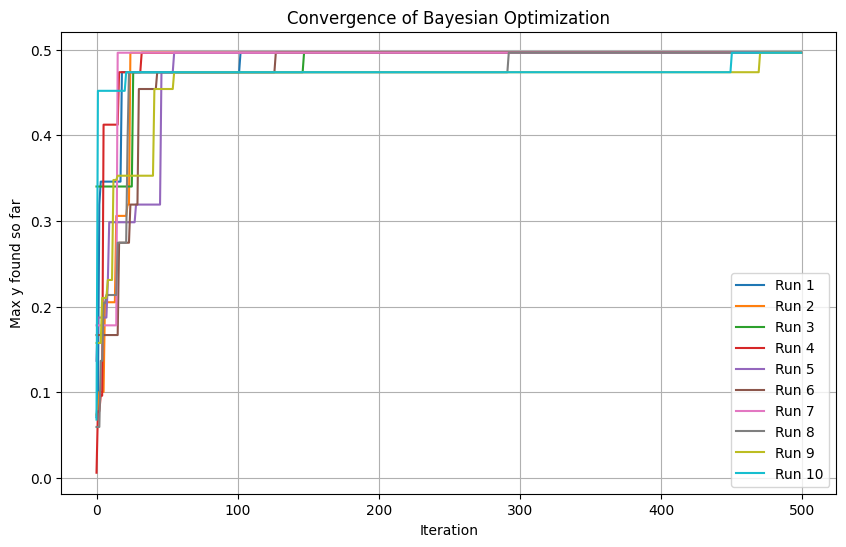

Random search mean max y: 0.48335590014128693
Random search standard deviation of max y: 0.031399238072509585


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the results from the BO
with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb') as file:
    bo_res = pickle.load(file)

# Initialize arrays to store the results
max_y_per_run = []
convergence_curves = []

# Loop over the runs to collect the max y values and convergence data
for r in range(nb_runs):
    ids_acquired = bo_res['ids_acquired'][r]
    y_values = y[ids_acquired]
    max_y_per_run.append(y_values.max())
    
    # Store the max y found so far for each iteration
    convergence_curve = [y_values[:i].max() for i in range(1, len(y_values) + 1)]
    convergence_curves.append(convergence_curve)

# Compute the mean and standard deviation of the max y values
mean_max_y = np.mean(max_y_per_run)
std_max_y = np.std(max_y_per_run)

print(f"Mean max y: {mean_max_y}")
print(f"Standard deviation of max y: {std_max_y}")

# Plot the convergence curves
plt.figure(figsize=(10, 6))
for r in range(nb_runs):
    plt.plot(convergence_curves[r], label=f'Run {r+1}')

plt.xlabel('Iteration')
plt.ylabel('Max y found so far')
plt.title('Convergence of Bayesian Optimization')
plt.legend()
plt.grid(True)
plt.show()

# Compare with random search
random_max_y = []
for _ in range(nb_runs):
    random_ids = np.random.choice(np.arange(X.shape[0]), size=nb_iterations, replace=False)
    random_y_values = y[random_ids]
    random_max_y.append(random_y_values.max())

mean_random_max_y = np.mean(random_max_y)
std_random_max_y = np.std(random_max_y)

print(f"Random search mean max y: {mean_random_max_y}")
print(f"Random search standard deviation of max y: {std_random_max_y}")


In [13]:
file_path = 'bo_results7.xlsx'
obtained_bo = pd.read_excel(file_path)
obtained_bo

Run  Iteration  COF ID   Y Value
0       0          0    4433  0.070727
1       0          1    3390  0.095735
2       0          2     216  0.319043
3       0          3     154  0.345857
4       0          4    1407  0.162767
...   ...        ...     ...       ...
4995    9        495    6909  0.000509
4996    9        496     216  0.319043
4997    9        497     364  0.274511
4998    9        498     441  0.247685
4999    9        499     364  0.274511

[5000 rows x 4 columns]

In [14]:
# Remove duplicates based on the 'cof id' column
obtained_bo = obtained_bo.drop_duplicates(subset=['COF ID'])
obtained_bo

Run  Iteration  COF ID   Y Value
0       0          0    4433  0.070727
1       0          1    3390  0.095735
2       0          2     216  0.319043
3       0          3     154  0.345857
4       0          4    1407  0.162767
...   ...        ...     ...       ...
4511    9         11    4568  0.068645
4512    9         12    2417  0.123184
4513    9         13    5872  0.032759
4514    9         14    4756  0.063409
4763    9        263    1794  0.146319

[206 rows x 4 columns]

In [15]:
unique_cof_ids = obtained_bo['COF ID'].unique()

# Filter the total_info_cleaned DataFrame to include only rows with indices in the unique_cof_ids
filtered_total_info = total_info_cleaned.loc[total_info_cleaned.index.isin(unique_cof_ids)]

# Save the filtered DataFrame back to Excel
filtered_total_info.to_excel('total_info_filtered.xlsx', index=False)
filtered_total_info

LISD      LFSD     LISFS  Unit_cell_volume   Density      ASA_A2  \
6     15.36203  13.23891  14.90651          67549.90  0.291845  10668.5000   
11    24.39556  13.22221  24.39556         102543.00  0.346494  15635.2000   
13    18.73744  15.64293  17.53200          99176.60  0.243844  13008.1000   
23    15.22577  13.94698  15.22577          16858.90  0.422713   2353.3300   
26    23.25293  13.11646  23.25293         102044.00  0.343144  15710.7000   
...        ...       ...       ...               ...       ...         ...   
6798   8.47106   5.41903   8.47106           9592.46  1.851980    650.3220   
6816   4.25914   3.85542   4.25422           2030.95  1.307420     24.5983   
6830   4.84076   4.64039   4.84076           1213.78  1.486990     68.2589   
6872   5.14219   3.36277   5.14219           1745.16  2.043840     69.2859   
6909  31.39938  26.27887  31.39936         212953.00  0.252736  16875.3000   

      ASA_m2_per_cm3  ASA_m2_per_g  NASA_A2  NASA_m2_per_cm3  ...  La  Cr  Ti  \
6           1579.350     5411.6100      0.0              0.0  ...   0   0   0   
11          1524.760     4400.5300      0.0              0.0  ...   0   0   0   
13          1311.610     5378.8700      0.0              0.0  ...   0   0   0   
23          1395.890     3302.2200      0.0              0.0  ...   0   0   0   
26          1539.600     4486.7600      0.0              0.0  ...   0   0   0   
...              ...           ...      ...              ...  ...  ..  ..  ..   
6798         677.951      366.0690      0.0              0.0  ...   0   0   0   
6816         121.117       92.6382      0.0              0.0  ...   0   0   0   
6830         562.367      378.1910      0.0              0.0  ...   0   0   0   
6872         397.018      194.2510      0.0              0.0  ...   0   0   0   
6909         792.440     3135.4500      0.0              0.0  ...   0   0   0   

      Ba  Rh  Ce  Cu  Al  Re     COP_R  
6      0   0   0   0   0   0  0.496410  
11     0   0   0   0   0   0  0.470049  
13     0   0   0   0   0   0  0.473648  
23     0   0   0   0   0   0  0.451912  
26     0   0   0   0   0   0  0.448578  
...   ..  ..  ..  ..  ..  ..       ...  
6798   0   0   0   0   0   0  0.003177  
6816   0   0   0   0   0   0  0.002622  
6830   0   0   0   4   0   0  0.002266  
6872   0   0   0   2   0   0  0.001590  
6909   0   0   0   0   0   0  0.000509  

[206 rows x 106 columns]

In [16]:
# Store the rest of the data objects which were not selected
not_selected_total_info = total_info_cleaned.loc[~total_info_cleaned.index.isin(unique_cof_ids)]
not_selected_total_info.to_excel('filtered_info_not_selected.xlsx', index=False)
not_selected_total_info

LISD      LFSD     LISFS  Unit_cell_volume   Density     ASA_A2  \
0     13.18217  10.20370  13.18217          6140.000  0.287208  1122.8100   
1     17.49700  17.44104  17.49700          2800.680  0.713223   390.5410   
2     22.00141  13.48659  22.00141         52812.600  0.303251  8995.1500   
3     14.37026  13.22660  14.37026         12821.800  0.356183  2130.4900   
4     18.13430  11.96931  18.13430         33152.200  0.311959  5856.6500   
...        ...       ...       ...               ...       ...        ...   
6912   6.56302   4.77517   6.56302          3664.890  1.599000   394.0410   
6913   5.67220   3.42753   4.50995          1630.010  2.827110    75.6807   
6914   4.90669   3.50214   4.90669           847.141  1.567280    37.4215   
6915   5.16636   4.13343   5.13222         17478.700  2.019600   806.0660   
6916   4.48832   3.71412   4.48832          1478.360  1.547160    47.6128   

      ASA_m2_per_cm3  ASA_m2_per_g  NASA_A2  NASA_m2_per_cm3  ...  La  Cr  Ti  \
0           1828.680      6367.080   0.0000            0.000  ...   0   0   0   
1           1394.450      1955.140   0.0000            0.000  ...   0   0   0   
2           1703.220      5616.540   0.0000            0.000  ...   0   0   0   
3           1661.620      4665.070   0.0000            0.000  ...   0   0   0   
4           1766.600      5662.900   0.0000            0.000  ...   0   0   0   
...              ...           ...      ...              ...  ...  ..  ..  ..   
6912        1075.180       672.406   0.0000            0.000  ...   0   0   0   
6913         464.295       164.230  67.0363          411.263  ...   0   0   0   
6914         441.738       281.850   0.0000            0.000  ...   0   0   0   
6915         461.169       228.346   0.0000            0.000  ...   0   0   0   
6916         322.064       208.165   0.0000            0.000  ...   0   0   0   

      Ba  Rh  Ce  Cu  Al  Re     COP_R  
0      0   0   0   2   0   0  0.583945  
1      0   0   0   0   0   0  0.542431  
2      0   0   0  24   0   0  0.522907  
3      0   0   0   8   0   0  0.515395  
4      0   0   0  12   0   0  0.512710  
...   ..  ..  ..  ..  ..  ..       ...  
6912   0   0   0   0   0   0  0.000327  
6913   2   0   0   0   0   0  0.000246  
6914   0   0   0   0   0   0  0.000137  
6915   0   0   0  64   0   0  0.000066  
6916   0   0   0   0   0   0  0.000000  

[6711 rows x 106 columns]

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.001561 | 14.36     | 3.852     | 7.856     | 199.7     |
| 2         | -0.001549 | 8.9       | 1.468     | 2.465     | 266.5     |
| 3         | -0.001558 | 20.03     | 3.124     | 2.165     | 292.5     |
| 4         | -0.001569 | 25.81     | 1.637     | 3.455     | 95.85     |
| 5         | -0.001552 | 12.61     | 2.574     | 5.456     | 122.8     |
| 6         | -0.001547 | 20.3      | 1.418     | 4.337     | 141.6     |
| 7         | -0.001568 | 16.4      | 3.356     | 3.597     | 178.6     |
| 8         | -0.001572 | 19.81     | 1.139     | 6.86      | 92.63     |
| 9         | -0.001566 | 6.626     | 3.847     | 9.725     | 252.1     |
| 10        | -0.00155  | 12.62     | 1.293     | 7.474     | 160.0     |
| 11        | -0.001554 | 7.504     | 1.815     | 8.528     | 144.6     |
| 12        | -0.001551 | 24.94     | 

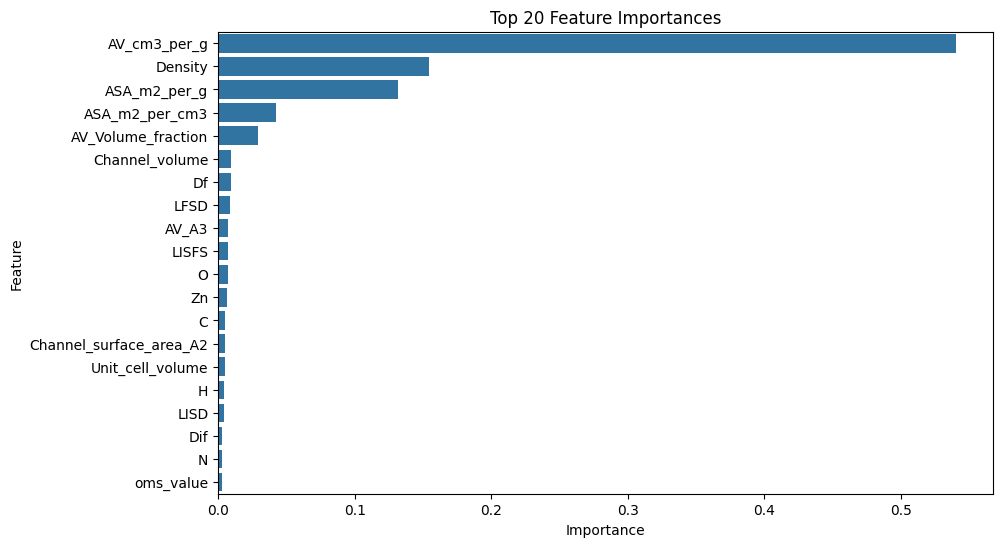

Number of important features: 27
Mean Squared Error: 0.0015442348619063625
R2 Score: 0.7607053503748782


In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Replace 'filtered_total_info.csv' and 'not_selected_total_info.csv' with the actual file paths
filtered_total_info = pd.read_excel('total_info_filtered.xlsx')
not_selected_total_info = pd.read_excel('filtered_info_not_selected.xlsx')

# Separate features and target variable
X_filtered = filtered_total_info.drop(columns=['COP_R'])
y_filtered = filtered_total_info['COP_R']
X_not_selected = not_selected_total_info.drop(columns=['COP_R'])
y_not_selected = not_selected_total_info['COP_R']

# Split the data into training and test sets
X_train, y_train = X_filtered, y_filtered
X_test, y_test = X_not_selected, y_not_selected

# Define the function for cross-validation
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Define the parameter bounds
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42
)

# Perform optimization
optimizer.maximize(
    init_points=10,
    n_iter=20
)

# Extract the best parameters
best_params = optimizer.max['params']
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf'])
}
print(f"Best parameters found: {best_params}")

# Train the Random Forest Regressor with the best parameters
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Calculate feature importance
importances = best_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Filter features based on importance threshold
threshold = 0.0005
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
print(f"Number of important features: {len(important_features)}")

# Select only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Train a new Random Forest Regressor with filtered features
rf_filtered = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = rf_filtered.predict(X_test_filtered)

# Evaluate the model accuracy using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate other metrics such as R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")
